# GJK

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import numpy as np

In [2]:
from pkg.tf_transform import *
from pkg.tf_robot import *
from pkg.constraint import *
from pkg.info import *
from pkg.tf_utils import *
from pkg.rotation_utils import *
from pkg.utils import *
from pkg.collision import *

In [3]:
import matplotlib.pyplot as plt
import time

## for test

In [4]:
gtimer = GlobalTimer()

In [5]:
N_vtx = 20

In [6]:
s1coords = np.loadtxt("s1.csv", delimiter=",")
s2coords = np.loadtxt("s2.csv", delimiter=",")

In [7]:
s1faces = np.loadtxt("s1face.csv", delimiter=",",dtype='int')
s2faces = np.loadtxt("s2face.csv", delimiter=",",dtype='int')

In [8]:
iterations = 6

In [9]:
s1verts = pad_vertex(s1coords.astype('float32'), N_vtx) # get_facepoints(s1coords, s1faces,N_fcs).astype('float32')
s2verts = pad_vertex(s2coords.astype('float32'), N_vtx) # get_facepoints(s2coords, s2faces,N_fcs).astype('float32')

In [10]:
S1Rot = np.array([
        [0.99847,0.016541,-0.052829,],
        [-0.014912,0.99941,0.031073,],
        [0.053311,-0.030238,0.99812,],
        ], dtype=np.float32)
S2Rot = np.array([
        [0.99752,0.065339,-0.026294,],
        [-0.063664,0.99616,0.060141,],
        [0.030123,-0.058318,0.99784,],
        ], dtype=np.float32)

In [11]:
s1points = tf.matmul(s1verts, np.transpose(S1Rot))+3
s2points = tf.matmul(s2verts, np.transpose(S2Rot))-3
FX1 = s1points
FX2 = s2points

## test batch

In [12]:
S1Rot = np.identity(3, dtype=np.float32)
S2Rot = np.identity(3, dtype=np.float32)
dang = np.deg2rad(5)
dS1 = np.transpose(np.matmul(Rot_axis(3,dang),np.matmul(Rot_axis(2,dang),Rot_axis(1,-dang)))).astype(np.float32)
dS2 = np.transpose(np.matmul(Rot_axis(3,-dang),np.matmul(Rot_axis(2,dang),Rot_axis(1,dang)))).astype(np.float32)
Dvec = np.reshape(np.arange(3,0.2,-0.005), (-1,1,1))
Rotvec1 = [np.matmul(dS1, S1Rot)]
Rotvec2 = [np.matmul(dS2, S2Rot)]
for i in range(1, len(Dvec)):
    Rotvec1 += [np.matmul(dS1, Rotvec1[i-1])]
    Rotvec2 += [np.matmul(dS2, Rotvec2[i-1])]
s1points = np.round(np.matmul(s1verts, np.transpose(Rotvec1, axes=[0,2,1]))+(1/2+Dvec/2), 4)
s2points = np.round(np.matmul(s2verts, np.transpose(Rotvec2, axes=[0,2,1]))-(1/2+Dvec/2), 4)
# FX1_batch = tf.constant([[s1points[2]]*len(s1points)],dtype='float32')
# FX2_batch = tf.constant([[s2points[2]]*len(s2points)],dtype='float32')

In [13]:
FX1_batch = tf.constant([s1points]*3,dtype='float32')
FX2_batch = tf.constant([s2points]*3,dtype='float32')
N_sim = FX1_batch.shape[0]
N_col = FX1_batch.shape[1]
flag_default = get_flag_default(N_sim, N_col)
dist_default = get_dist_default(N_sim, N_col)
v_batch = np.array([[[[0.8000, 0.5000, 1.0000]]]*N_col]*N_sim,dtype=np.float32)
gtimer.reset()
dist_vec1 = []
flag_vec1 = []
avec1 = []
bvec1 = []
cvec1 = []
dvec1 = []
itervec1 = []
for _ in range(10):
    gtimer.tic("TF_batch")
#     dist, flag = test_collision_batch(FX1_batch, FX2_batch, v_batch,flag_default,dist_default,10)
    a, b = pickLineTF_batch(v_batch, FX2_batch, FX1_batch)
    a, b, c, flag = PickTriangleTF_batch(a,b,FX2_batch,FX1_batch,flag_default)
    a,b,c,d,v, v_, dist,flag, iter = pickTetrahedronTF_batch(a,b,c,FX2_batch,FX1_batch,flag_default,dist_default)
#     avec1 += [a[0][:,:]]
#     bvec1 += [b[0][:,:]]
#     cvec1 += [c[0][:,:]]
#     dvec1 += [d[0][:,:]]
#     itervec1 += [iter]
    dist_vec1 += [dist[0][:,0]]
    flag_vec1 += [flag[0][:,0]]
    gtimer.toc("TF_batch")
gtimer.print_time_log()
dist_vec1 = np.array(dist_vec1[0])

TF_batch: 	2785.0 ms/10 = 278.546 ms


(-0.5, 6.0)

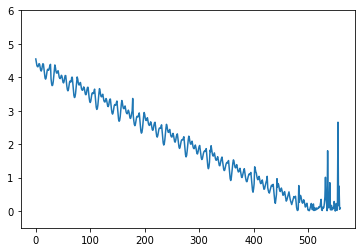

In [14]:
plt.plot(dist_vec1)
# plt.plot(np.array(flag_vec1[0]),'o')
plt.ylim([-5e-1, 6])

### plot 3d

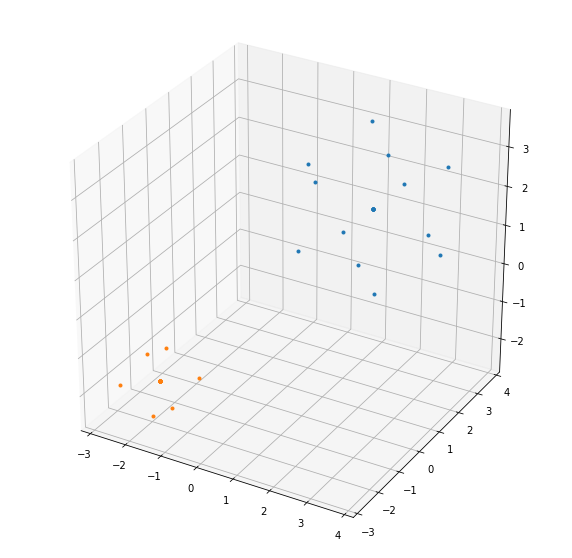

In [15]:

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as mplot3d

fig = plt.figure(figsize=(10, 10))
i_col = 57

sub = fig.add_subplot(1,1,1,projection="3d")
x, y, z = np.transpose(FX1_batch[0,i_col])
sub.plot(x,y,z,'.')
x, y, z = np.transpose(FX2_batch[0,i_col])
sub.plot(x,y,z,'.')

# template distance

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import numpy as np

In [2]:
from pkg.tf_transform import *
from pkg.tf_robot import *
from pkg.constraint import *
from pkg.info import *
from pkg.tf_utils import *
from pkg.rotation_utils import *
from pkg.utils import *
from pkg.collision import *

In [3]:
import matplotlib.pyplot as plt
import time

In [4]:
from pkg.distance import *

In [5]:
N_sim = 50
N_col = 20

In [20]:
pt1 = tf.constant([[[[1e-3,3,3]]]*N_col]*N_sim, dtype=tf.float32)
pt2 = tf.constant([[[[1,0,1]]]*N_col]*N_sim, dtype=tf.float32)
ln1 = tf.constant([[[[2,0,0],[0,2,-2+1e-3]]]*N_col]*N_sim, dtype=tf.float32)
ln2 = tf.constant([[[[-2,1+1e-3,0],[0,1,-2+1e-3]]]*N_col]*N_sim, dtype=tf.float32)
pl1 = tf.constant([[[[1,0+1e-3,0],[0,0+1e-3,-1],[-1,0+1e-3,0],[0,0+1e-3,1]]]*N_col]*N_sim, dtype=tf.float32)
pl2 = tf.constant([[[[1+1e-3,1,0],[0,1,-1],[-1,1,0],[0,1,1]]]*N_col]*N_sim, dtype=tf.float32)
bx1 = tf.constant( np.array(
    [[tf.concat([pl1[0,0]-tf.constant([[0,2,0]], dtype=tf.float32), 
                 pl1[0,0]-tf.constant([[0,3,0]], dtype=tf.float32)], 
                axis=0)]*N_col]*N_sim), 
                  dtype=tf.float32)
bx2 = tf.constant( np.array(
    [[tf.concat([pl2[0,0]+tf.constant([[0,1,0]], dtype=tf.float32), 
                 pl2[0,0]-tf.constant([[0,1,0]], dtype=tf.float32)], 
                axis=0)]*N_col]*N_sim), 
                  dtype=tf.float32)
dist1 = tf.constant([[[0]]*N_col]*N_sim, dtype=tf.float32)
dist2 = tf.constant([[[0]]*N_col]*N_sim, dtype=tf.float32)
flag_default = get_flag_default(N_sim, N_col)
dist_default = get_dist_default(N_sim, N_col)
x_batch, y_batch = get_xy_batch(N_sim, N_col)
zeros_pt = get_zero_points(N_sim, N_col)

In [7]:
# gtimer = GlobalTimer()
# gtimer.reset()
# for _ in range(100):
#     gtimer.tic("all")
#     dist1_, dist2_, dist3_, dist4_, dist5_, dist6_, dist7_, dist8_, dist9_, dist10_ = \
#         test_all(pt1, pt2, ln1, ln2, pl1, pl2, bx1, bx2, dist1, dist2, zeros_pt, N_sim, N_col, flag_default, dist_default, x_batch, y_batch)
#     gtimer.toc("all")
# print(gtimer)

In [8]:
pt1 = tf.constant([[[[1e-3,3,3]]]*N_col]*N_sim, dtype=tf.float32)
pt2 = tf.constant([[[[1,0,1]]]*N_col]*N_sim, dtype=tf.float32)
ln1 = tf.constant([[[[2,0,0],[0,2,-2+1e-3]]]*N_col]*N_sim, dtype=tf.float32)
ln2 = tf.constant([[[[-2,1+1e-3,0],[0,1,-2+1e-3]]]*N_col]*N_sim, dtype=tf.float32)
pl1 = tf.constant([[[[1,0+1e-3,0],[0,0+1e-3,-1],[-1,0+1e-3,0],[0,0+1e-3,1]]]*N_col]*N_sim, dtype=tf.float32)
pl2 = tf.constant([[[[1+1e-3,1,0],[0,1,-1],[-1,1,0],[0,1,1]]]*N_col]*N_sim, dtype=tf.float32)
bx1 = tf.constant( np.array(
    [[tf.concat([pl1[0,0]-tf.constant([[0,2,0]], dtype=tf.float32), 
                 pl1[0,0]-tf.constant([[0,3,0]], dtype=tf.float32)], 
                axis=0)]*N_col]*N_sim), 
                  dtype=tf.float32)
bx2 = tf.constant( np.array(
    [[tf.concat([pl2[0,0]+tf.constant([[0,1,0]], dtype=tf.float32), 
                 pl2[0,0]-tf.constant([[0,1,0]], dtype=tf.float32)], 
                axis=0)]*N_col]*N_sim), 
                  dtype=tf.float32)
dist1 = tf.constant([[[0]]*N_col]*N_sim, dtype=tf.float32)
dist2 = tf.constant([[[0]]*N_col]*N_sim, dtype=tf.float32)
flag_default = get_flag_default(N_sim, N_col)
dist_default = get_dist_default(N_sim, N_col)
x_batch, y_batch = get_xy_batch(N_sim, N_col)
zeros_pt = get_zero_points(N_sim, N_col)

In [9]:
dist, vec, flag = distance_pt_pt(pt1, pt2, dist1, dist2)

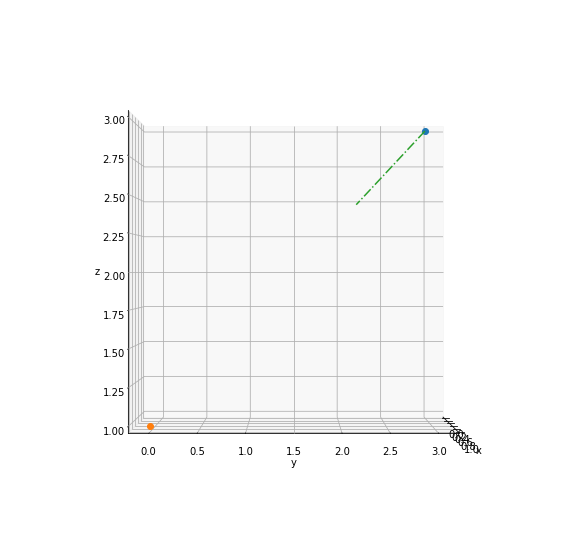

In [10]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as mplot3d

fig = plt.figure(figsize=(10, 10))
sub = fig.add_subplot(1,1,1,projection="3d")
x,y,z = np.transpose(pt1[0,0])
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(pt2[0,0])
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(np.pad(vec[0,0:1], [[1,0],[0,0]])+pt1[0,0])
sub.plot(x,y,z,'-.')
sub.set_xlabel('x')
sub.set_ylabel('y')
sub.set_zlabel('z')

sub.view_init(elev=0, azim=0)

In [11]:
pt1 = tf.constant([[[[1e-3,3,3]]]*N_col]*N_sim, dtype=tf.float32)
dist, vec, flag = distance_pt_ln(pt1, ln2, dist1, dist2)

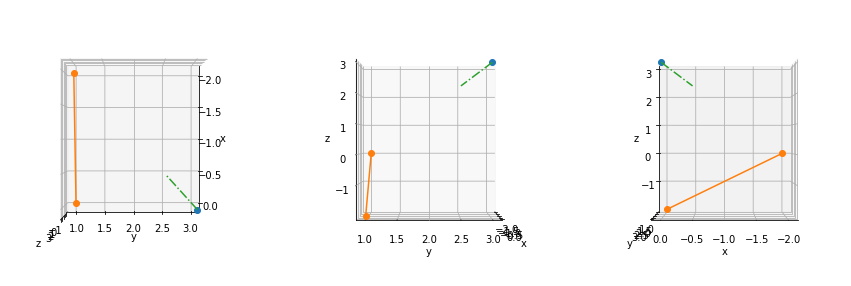

In [12]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as mplot3d

fig = plt.figure(figsize=(15, 5))
sub = fig.add_subplot(1,3,1,projection="3d")
x,y,z = np.transpose(pt1[0,0])
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(ln2[0,0])
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(np.pad(vec[0,0:1], [[1,0],[0,0]])+pt1[0,0,0:1])
sub.plot(x,y,z,'-.')
sub.set_xlabel('x')
sub.set_ylabel('y')
sub.set_zlabel('z')

sub.view_init(elev=90, azim=0)

sub = fig.add_subplot(1,3,2,projection="3d")
x,y,z = np.transpose(pt1[0,0])
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(ln2[0,0])
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(np.pad(vec[0,0:1], [[1,0],[0,0]])+pt1[0,0,0:1])
sub.plot(x,y,z,'-.')
sub.set_xlabel('x')
sub.set_ylabel('y')
sub.set_zlabel('z')

sub.view_init(elev=0, azim=0)

sub = fig.add_subplot(1,3,3,projection="3d")
x,y,z = np.transpose(pt1[0,0])
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(ln2[0,0])
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(np.pad(vec[0,0:1], [[1,0],[0,0]])+pt1[0,0,0:1])
sub.plot(x,y,z,'-.')
sub.set_xlabel('x')
sub.set_ylabel('y')
sub.set_zlabel('z')

sub.view_init(elev=0, azim=90)

In [13]:
pt1 = tf.constant([[[[+1e-3,3,0]]]*N_col]*N_sim, dtype=tf.float32)
dist, vec, flag = distance_pt_pl(pt1, pl2, dist1, dist2, N_sim, N_col)
print(dist[0,0])

tf.Tensor([1.9999999], shape=(1,), dtype=float32)


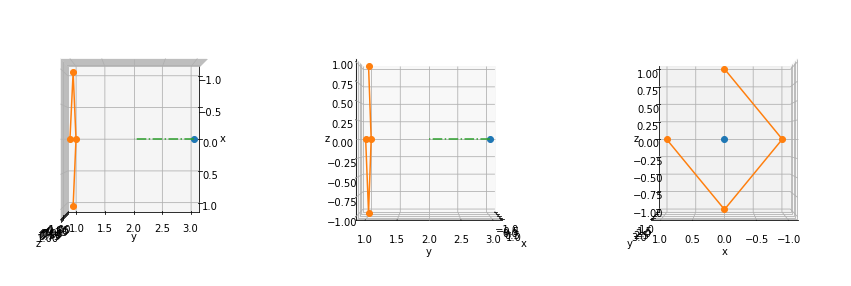

In [14]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as mplot3d

fig = plt.figure(figsize=(15, 5))
sub = fig.add_subplot(1,3,1,projection="3d")
x,y,z = np.transpose(pt1[0,0])
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(pl2[0,0])
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(np.pad(vec[0,0:1], [[1,0],[0,0]])+pt1[0,0,0:1])
sub.plot(x,y,z,'-.')
sub.set_xlabel('x')
sub.set_ylabel('y')
sub.set_zlabel('z')

sub.view_init(elev=90, azim=0)

sub = fig.add_subplot(1,3,2,projection="3d")
x,y,z = np.transpose(pt1[0,0])
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(pl2[0,0])
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(np.pad(vec[0,0:1], [[1,0],[0,0]])+pt1[0,0,0:1])
sub.plot(x,y,z,'-.')
sub.set_xlabel('x')
sub.set_ylabel('y')
sub.set_zlabel('z')

sub.view_init(elev=0, azim=0)

sub = fig.add_subplot(1,3,3,projection="3d")
x,y,z = np.transpose(pt1[0,0])
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(pl2[0,0])
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(np.pad(vec[0,0:1], [[1,0],[0,0]])+pt1[0,0,0:1])
sub.plot(x,y,z,'-.')
sub.set_xlabel('x')
sub.set_ylabel('y')
sub.set_zlabel('z')

sub.view_init(elev=0, azim=90)

In [15]:
pt1 = tf.constant([[[[3+1e-3,-1,3]]]*N_col]*N_sim, dtype=tf.float32)
bx2 = tf.constant( np.array(
    [[tf.concat([pl2[0,0]+tf.constant([[0,1,0]], dtype=tf.float32), 
                 pl2[0,0]-tf.constant([[0,1,0]], dtype=tf.float32)], 
                axis=0)]*N_col]*N_sim), 
                  dtype=tf.float32)
dist, vec, flag = distance_pt_bx(pt1, bx2, dist1, dist2, N_sim, N_col)
print(dist[0,0])

tf.Tensor([3.674574], shape=(1,), dtype=float32)


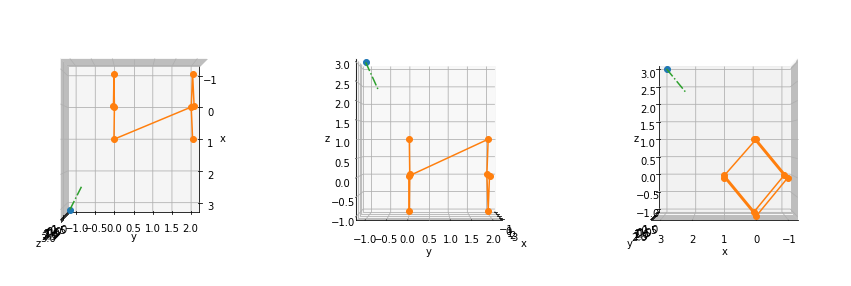

In [16]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as mplot3d

fig = plt.figure(figsize=(15, 5))
sub = fig.add_subplot(1,3,1,projection="3d")
x,y,z = np.transpose(pt1[0,0])
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(bx2[0,0])
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(np.pad(vec[0,0:1], [[1,0],[0,0]])+pt1[0,0,0:1])
sub.plot(x,y,z,'-.')
sub.set_xlabel('x')
sub.set_ylabel('y')
sub.set_zlabel('z')

sub.view_init(elev=90, azim=0)

sub = fig.add_subplot(1,3,2,projection="3d")
x,y,z = np.transpose(pt1[0,0])
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(bx2[0,0])
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(np.pad(vec[0,0:1], [[1,0],[0,0]])+pt1[0,0,0:1])
sub.plot(x,y,z,'-.')
sub.set_xlabel('x')
sub.set_ylabel('y')
sub.set_zlabel('z')

sub.view_init(elev=0, azim=0)

sub = fig.add_subplot(1,3,3,projection="3d")
x,y,z = np.transpose(pt1[0,0])
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(bx2[0,0])
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(np.pad(vec[0,0:1], [[1,0],[0,0]])+pt1[0,0,0:1])
sub.plot(x,y,z,'-.')
sub.set_xlabel('x')
sub.set_ylabel('y')
sub.set_zlabel('z')

sub.view_init(elev=0, azim=90)

In [17]:
ln1 = tf.constant([[[[2,0,0],[0,2,-2+1e-3]]]*N_col]*N_sim, dtype=tf.float32)
ln2 = tf.constant([[[[-2,1+1e-3,0],[0,1,-2+1e-3]]]*N_col]*N_sim, dtype=tf.float32)
dist, vec, flag = distance_ln_ln(ln1, ln2, dist1, dist2, N_sim, N_col, zeros_pt)
print(dist[0,0])
print(vec[0,0])

tf.Tensor([0.81642854], shape=(1,), dtype=float32)
tf.Tensor([-0.40841845 -0.81642854 -0.40821424], shape=(3,), dtype=float32)


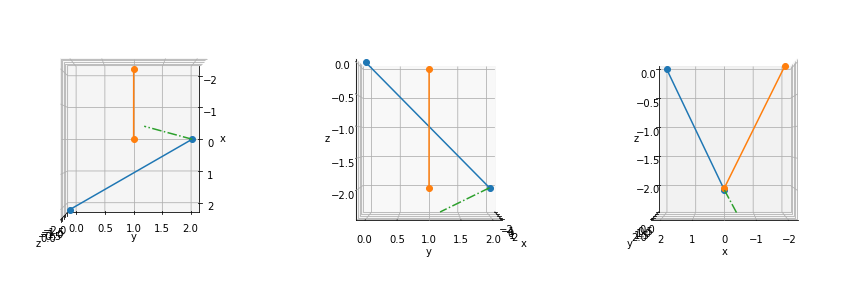

In [18]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as mplot3d

fig = plt.figure(figsize=(15, 5))
sub = fig.add_subplot(1,3,1,projection="3d")
x,y,z = np.transpose(ln1[0,0])
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(ln2[0,0])
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(np.pad(vec[0,0:1], [[1,0],[0,0]])+ln1[0,0,1:2])
sub.plot(x,y,z,'-.')
sub.set_xlabel('x')
sub.set_ylabel('y')
sub.set_zlabel('z')

sub.view_init(elev=90, azim=0)

sub = fig.add_subplot(1,3,2,projection="3d")
x,y,z = np.transpose(ln1[0,0])
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(ln2[0,0])
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(np.pad(vec[0,0:1], [[1,0],[0,0]])+ln1[0,0,1:2])
sub.plot(x,y,z,'-.')
sub.set_xlabel('x')
sub.set_ylabel('y')
sub.set_zlabel('z')

sub.view_init(elev=0, azim=0)

sub = fig.add_subplot(1,3,3,projection="3d")
x,y,z = np.transpose(ln1[0,0])
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(ln2[0,0])
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(np.pad(vec[0,0:1], [[1,0],[0,0]])+ln1[0,0,1:2])
sub.plot(x,y,z,'-.')
sub.set_xlabel('x')
sub.set_ylabel('y')
sub.set_zlabel('z')

sub.view_init(elev=0, azim=90)

In [19]:
ln1 = tf.constant([[[[2,2,0],[0,4,-2+1e-3]]]*N_col]*N_sim, dtype=tf.float32)
dist, vec, flag = distance_ln_pl(ln1, pl2, dist1, dist2, N_sim, N_col, zeros_pt)

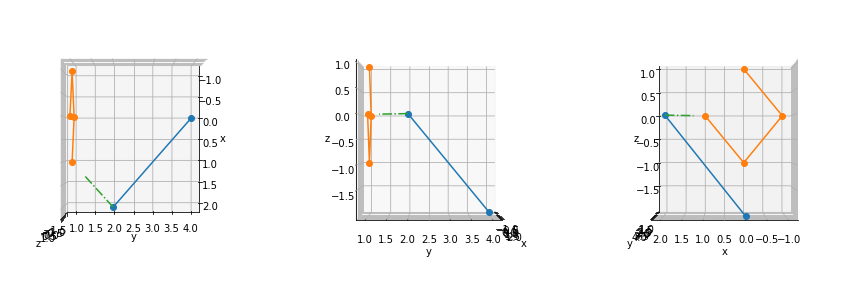

In [20]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as mplot3d

offset = ln1[0,0,0:1]

fig = plt.figure(figsize=(15, 5))
sub = fig.add_subplot(1,3,1,projection="3d")
x,y,z = np.transpose(ln1[0,0])
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(pl2[0,0])
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(np.pad(vec[0,0:1], [[1,0],[0,0]])+offset)
sub.plot(x,y,z,'-.')
sub.set_xlabel('x')
sub.set_ylabel('y')
sub.set_zlabel('z')

sub.view_init(elev=90, azim=0)

sub = fig.add_subplot(1,3,2,projection="3d")
x,y,z = np.transpose(ln1[0,0])
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(pl2[0,0])
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(np.pad(vec[0,0:1], [[1,0],[0,0]])+offset)
sub.plot(x,y,z,'-.')
sub.set_xlabel('x')
sub.set_ylabel('y')
sub.set_zlabel('z')

sub.view_init(elev=0, azim=0)

sub = fig.add_subplot(1,3,3,projection="3d")
x,y,z = np.transpose(ln1[0,0])
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(pl2[0,0])
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(np.pad(vec[0,0:1], [[1,0],[0,0]])+offset)
sub.plot(x,y,z,'-.')
sub.set_xlabel('x')
sub.set_ylabel('y')
sub.set_zlabel('z')

sub.view_init(elev=0, azim=90)

In [21]:
ln1 = tf.constant([[[[2,2,0],[0,4,-2+1e-3]]]*N_col]*N_sim, dtype=tf.float32)
bx2 = tf.constant( np.array(
    [[tf.concat([pl2[0,0]+tf.constant([[0,1,0]], dtype=tf.float32), 
                 pl2[0,0]-tf.constant([[0,1,0]], dtype=tf.float32)], 
                axis=0)]*N_col]*N_sim), 
                  dtype=tf.float32)

In [22]:
dist, vec, flag = distance_ln_bx(ln1, bx2, dist1, dist2, N_sim, N_col, zeros_pt)
print(dist[0,0])
print(vec[0,0])

tf.Tensor([0.81561196], shape=(1,), dtype=float32)
tf.Tensor([-0.8164285  -0.4084184   0.40821418], shape=(3,), dtype=float32)


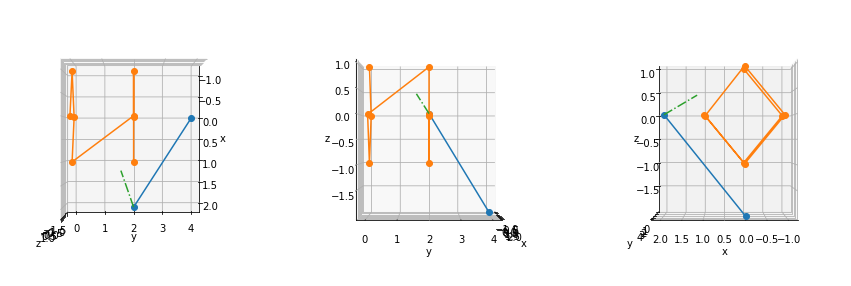

In [23]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as mplot3d

offset = ln1[0,0,0:1]

fig = plt.figure(figsize=(15, 5))
sub = fig.add_subplot(1,3,1,projection="3d")
x,y,z = np.transpose(ln1[0,0])
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(bx2[0,0])
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(np.pad(vec[0,0:1], [[1,0],[0,0]])+offset)
sub.plot(x,y,z,'-.')
sub.set_xlabel('x')
sub.set_ylabel('y')
sub.set_zlabel('z')

sub.view_init(elev=90, azim=0)

sub = fig.add_subplot(1,3,2,projection="3d")
x,y,z = np.transpose(ln1[0,0])
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(bx2[0,0])
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(np.pad(vec[0,0:1], [[1,0],[0,0]])+offset)
sub.plot(x,y,z,'-.')
sub.set_xlabel('x')
sub.set_ylabel('y')
sub.set_zlabel('z')

sub.view_init(elev=0, azim=0)

sub = fig.add_subplot(1,3,3,projection="3d")
x,y,z = np.transpose(ln1[0,0])
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(bx2[0,0])
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(np.pad(vec[0,0:1], [[1,0],[0,0]])+offset)
sub.plot(x,y,z,'-.')
sub.set_xlabel('x')
sub.set_ylabel('y')
sub.set_zlabel('z')

sub.view_init(elev=0, azim=90)

In [24]:
dist, vec, flag = distance_pl_pl(pl1, pl2, dist1, dist2, flag_default, dist_default, x_batch, y_batch)

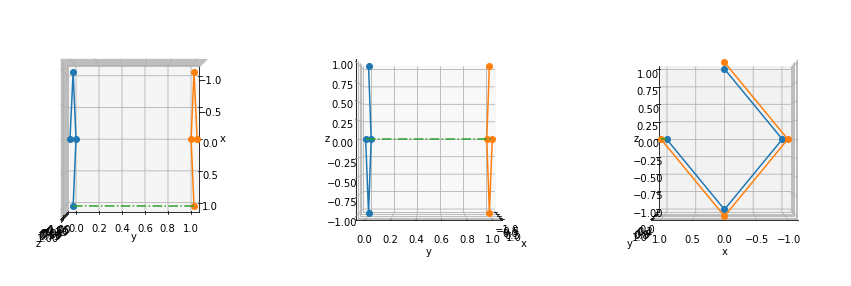

In [25]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as mplot3d

offset = pl1[0,0,0:1]
X1 = pl1[0,0]
X2 = pl2[0,0]

fig = plt.figure(figsize=(15, 5))
sub = fig.add_subplot(1,3,1,projection="3d")
x,y,z = np.transpose(X1)
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(X2)
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(np.pad(vec[0,0:1], [[1,0],[0,0]])+offset)
sub.plot(x,y,z,'-.')
sub.set_xlabel('x')
sub.set_ylabel('y')
sub.set_zlabel('z')

sub.view_init(elev=90, azim=0)

sub = fig.add_subplot(1,3,2,projection="3d")
x,y,z = np.transpose(X1)
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(X2)
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(np.pad(vec[0,0:1], [[1,0],[0,0]])+offset)
sub.plot(x,y,z,'-.')
sub.set_xlabel('x')
sub.set_ylabel('y')
sub.set_zlabel('z')

sub.view_init(elev=0, azim=0)

sub = fig.add_subplot(1,3,3,projection="3d")
x,y,z = np.transpose(X1)
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(X2)
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(np.pad(vec[0,0:1], [[1,0],[0,0]])+offset)
sub.plot(x,y,z,'-.')
sub.set_xlabel('x')
sub.set_ylabel('y')
sub.set_zlabel('z')

sub.view_init(elev=0, azim=90)

In [33]:
pl1 = tf.constant([[[[1,-1+1e-3,0],[0,-1+1e-3,-1],[-1,-1+1e-3,0],[0,-1+1e-3,1]]]*N_col]*N_sim, dtype=tf.float32)
pl2 = tf.constant([[[[1+1e-3,1,0],[0,1,-1],[-1,1,0],[0,1,1]]]*N_col]*N_sim, dtype=tf.float32)
bx1 = tf.constant( np.array(
    [[tf.concat([pl1[0,0]-tf.constant([[0,2,0]], dtype=tf.float32), 
                 pl1[0,0]-tf.constant([[0,3,0]], dtype=tf.float32)], 
                axis=0)]*N_col]*N_sim), 
                  dtype=tf.float32)
bx2 = tf.constant( np.array(
    [[tf.concat([pl2[0,0]+tf.constant([[0,1,0]], dtype=tf.float32), 
                 pl2[0,0]-tf.constant([[0,1,0]], dtype=tf.float32)], 
                axis=0)]*N_col]*N_sim), 
                  dtype=tf.float32)

In [34]:
dist, vec, flag = distance_pl_bx(pl1, bx2, dist1, dist2, flag_default, dist_default, x_batch, y_batch)
print(dist[0,0])
print(vec[0,0])

tf.Tensor([0.99900013], shape=(1,), dtype=float32)
tf.Tensor([0.        0.9999999 0.       ], shape=(3,), dtype=float32)


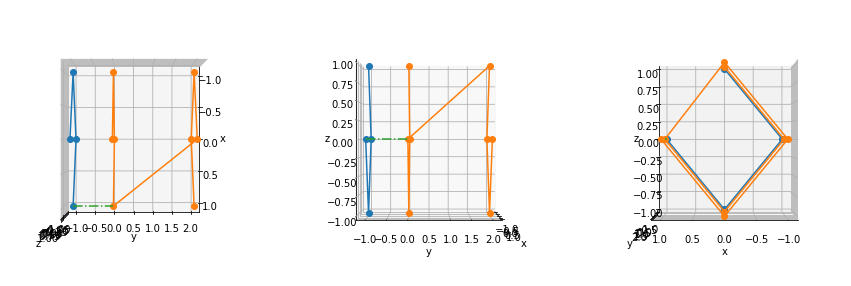

In [35]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as mplot3d

offset = pl1[0,0,0:1]
X1 = pl1[0,0]
X2 = bx2[0,0]

fig = plt.figure(figsize=(15, 5))
sub = fig.add_subplot(1,3,1,projection="3d")
x,y,z = np.transpose(X1)
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(X2)
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(np.pad(vec[0,0:1], [[1,0],[0,0]])+offset)
sub.plot(x,y,z,'-.')
sub.set_xlabel('x')
sub.set_ylabel('y')
sub.set_zlabel('z')

sub.view_init(elev=90, azim=0)

sub = fig.add_subplot(1,3,2,projection="3d")
x,y,z = np.transpose(X1)
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(X2)
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(np.pad(vec[0,0:1], [[1,0],[0,0]])+offset)
sub.plot(x,y,z,'-.')
sub.set_xlabel('x')
sub.set_ylabel('y')
sub.set_zlabel('z')

sub.view_init(elev=0, azim=0)

sub = fig.add_subplot(1,3,3,projection="3d")
x,y,z = np.transpose(X1)
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(X2)
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(np.pad(vec[0,0:1], [[1,0],[0,0]])+offset)
sub.plot(x,y,z,'-.')
sub.set_xlabel('x')
sub.set_ylabel('y')
sub.set_zlabel('z')

sub.view_init(elev=0, azim=90)

In [29]:
dist, vec, flag = distance_bx_bx(bx1, bx2, dist1, dist2, flag_default, dist_default, x_batch, y_batch)

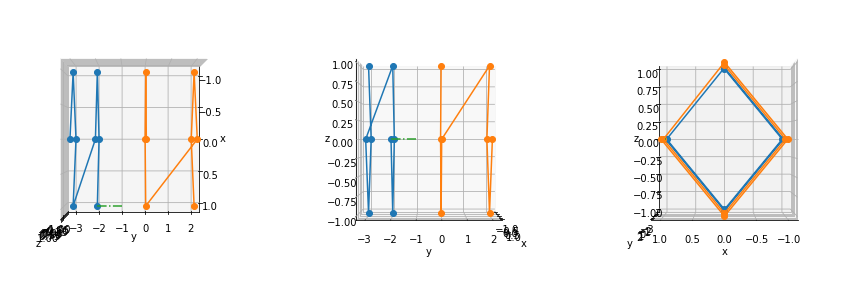

In [30]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as mplot3d

offset = bx1[0,0,0:1]
X1 = bx1[0,0]
X2 = bx2[0,0]

fig = plt.figure(figsize=(15, 5))
sub = fig.add_subplot(1,3,1,projection="3d")
x,y,z = np.transpose(X1)
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(X2)
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(np.pad(vec[0,0:1], [[1,0],[0,0]])+offset)
sub.plot(x,y,z,'-.')
sub.set_xlabel('x')
sub.set_ylabel('y')
sub.set_zlabel('z')

sub.view_init(elev=90, azim=0)

sub = fig.add_subplot(1,3,2,projection="3d")
x,y,z = np.transpose(X1)
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(X2)
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(np.pad(vec[0,0:1], [[1,0],[0,0]])+offset)
sub.plot(x,y,z,'-.')
sub.set_xlabel('x')
sub.set_ylabel('y')
sub.set_zlabel('z')

sub.view_init(elev=0, azim=0)

sub = fig.add_subplot(1,3,3,projection="3d")
x,y,z = np.transpose(X1)
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(X2)
sub.plot(x,y,z,'-o')
x,y,z = np.transpose(np.pad(vec[0,0:1], [[1,0],[0,0]])+offset)
sub.plot(x,y,z,'-.')
sub.set_xlabel('x')
sub.set_ylabel('y')
sub.set_zlabel('z')

sub.view_init(elev=0, azim=90)

In [1]:
# Disable GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import numpy as np

In [3]:
from pkg.tf_transform import *
from pkg.tf_robot import *
from pkg.constraint import *
from pkg.info import *
from pkg.tf_utils import *
from pkg.rotation_utils import *
from pkg.utils import *
from pkg.collision import *

In [4]:
import matplotlib.pyplot as plt
import time

In [5]:
from pkg.distance import *

In [41]:
N_sim = 1
N_col = 30

In [42]:
pt1 = tf.constant([[[[1e-3,3,3]]]*N_col]*N_sim, dtype=tf.float32)
pt2 = tf.constant([[[[1,0,1]]]*N_col]*N_sim, dtype=tf.float32)
ln1 = tf.constant([[[[2,0,0],[0,2,-2+1e-3]]]*N_col]*N_sim, dtype=tf.float32)
ln2 = tf.constant([[[[-2,1+1e-3,0],[0,1,-2+1e-3]]]*N_col]*N_sim, dtype=tf.float32)
pl1 = tf.constant([[[[1,0+1e-3,0],[0,0+1e-3,-1],[-1,0+1e-3,0],[0,0+1e-3,1]]]*N_col]*N_sim, dtype=tf.float32)
pl2 = tf.constant([[[[1+1e-3,1,0],[0,1,-1],[-1,1,0],[0,1,1]]]*N_col]*N_sim, dtype=tf.float32)
bx1 = tf.constant( np.array(
    [[tf.concat([pl1[0,0]-tf.constant([[0,2,0]], dtype=tf.float32), 
                 pl1[0,0]-tf.constant([[0,3,0]], dtype=tf.float32)], 
                axis=0)]*N_col]*N_sim), 
                  dtype=tf.float32)
bx2 = tf.constant( np.array(
    [[tf.concat([pl2[0,0]+tf.constant([[0,1,0]], dtype=tf.float32), 
                 pl2[0,0]-tf.constant([[0,1,0]], dtype=tf.float32)], 
                axis=0)]*N_col]*N_sim), 
                  dtype=tf.float32)
dist1 = tf.constant([[[0]]*N_col]*N_sim, dtype=tf.float32)
dist2 = tf.constant([[[0]]*N_col]*N_sim, dtype=tf.float32)
flag_default = get_flag_default(N_sim, N_col)
dist_default = get_dist_default(N_sim, N_col)
x_batch, y_batch = get_xy_batch(N_sim, N_col)
zeros_pt = get_zero_points(N_sim, N_col)

In [43]:
from pkg.distance import *

In [44]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as mplot3d


In [46]:
gtimer = GlobalTimer()
gtimer.reset()
distvec = []
distrefvec = []
distcompvec = []
flagcompvec = []
for _ in range(1):
    gtimer.tic("pt_pt")
    dist, vec, flag = distance_pt_pt(pt1, pt2, dist1, dist2)
    gtimer.toc("pt_pt")
    distvec += [dist]
    dist_ref, vec_ref, flag_ref = distance_mesh(pt1, pt2, dist1, dist2, flag_default, dist_default, x_batch, y_batch, IterationAllowed=6)
    distrefvec += [dist_ref]
    distcompvec += [dist-dist_ref]
    flagcompvec += [tf.cast(flag, tf.int32)-tf.cast(flag_ref, tf.int32)]
    gtimer.tic("pt_ln")
    dist, vec, flag = distance_pt_ln(pt1, ln2, dist1, dist2)
    gtimer.toc("pt_ln")
    distvec += [dist]
    dist_ref, vec_ref, flag_ref = distance_mesh(pt1, ln2, dist1, dist2, flag_default, dist_default, x_batch, y_batch, IterationAllowed=6)
    distrefvec += [dist_ref]
    distcompvec += [dist-dist_ref]
    flagcompvec += [tf.cast(flag, tf.int32)-tf.cast(flag_ref, tf.int32)]
    gtimer.tic("pt_pl")
    dist, vec, flag = distance_pt_pl(pt1, pl2, dist1, dist2, N_sim, N_col)
    gtimer.toc("pt_pl")
    distvec += [dist]
    dist_ref, vec_ref, flag_ref = distance_mesh(pt1, pl2, dist1, dist2, flag_default, dist_default, x_batch, y_batch, IterationAllowed=6)
    distrefvec += [dist_ref]
    distcompvec += [dist-dist_ref]
    flagcompvec += [tf.cast(flag, tf.int32)-tf.cast(flag_ref, tf.int32)]
    gtimer.tic("pt_bx")
    dist, vec, flag = distance_pt_bx(pt1, bx2, dist1, dist2, N_sim, N_col)
    gtimer.toc("pt_bx")
    distvec += [dist]
    dist_ref, vec_ref, flag_ref = distance_mesh(pt1, bx2, dist1, dist2, flag_default, dist_default, x_batch, y_batch, IterationAllowed=6)
    distrefvec += [dist_ref]
    distcompvec += [dist-dist_ref]
    flagcompvec += [tf.cast(flag, tf.int32)-tf.cast(flag_ref, tf.int32)]
    gtimer.tic("ln_ln")
    dist, vec, flag = distance_ln_ln(ln1, ln2, dist1, dist2, N_sim, N_col, zeros_pt)
    gtimer.toc("ln_ln")
    distvec += [dist]
    dist_ref, vec_ref, flag_ref = distance_mesh(ln1, ln2, dist1, dist2, flag_default, dist_default, x_batch, y_batch, IterationAllowed=6)
    distrefvec += [dist_ref]
    distcompvec += [dist-dist_ref]
    flagcompvec += [tf.cast(flag, tf.int32)-tf.cast(flag_ref, tf.int32)]
    gtimer.tic("ln_pl")
    dist, vec, flag = distance_ln_pl(ln1, pl2, dist1, dist2, N_sim, N_col, zeros_pt)
    gtimer.toc("ln_pl")
    distvec += [dist]
    dist_ref, vec_ref, flag_ref = distance_mesh(ln1, pl2, dist1, dist2, flag_default, dist_default, x_batch, y_batch, IterationAllowed=6)
    distrefvec += [dist_ref]
    distcompvec += [dist-dist_ref]
    flagcompvec += [tf.cast(flag, tf.int32)-tf.cast(flag_ref, tf.int32)]
    gtimer.tic("ln_bx")
    dist, vec, flag = distance_ln_bx(ln1, bx2, dist1, dist2, N_sim, N_col, zeros_pt)
    gtimer.toc("ln_bx")
    distvec += [dist]
    dist_ref, vec_ref, flag_ref = distance_mesh(ln1, bx2, dist1, dist2, flag_default, dist_default, x_batch, y_batch, IterationAllowed=6)
    distrefvec += [dist_ref]
    distcompvec += [dist-dist_ref]
    flagcompvec += [tf.cast(flag, tf.int32)-tf.cast(flag_ref, tf.int32)]
    gtimer.tic("pl_pl")
    dist, vec, flag = distance_pl_pl(pl1, pl2, dist1, dist2, flag_default, dist_default, x_batch, y_batch)
    gtimer.toc("pl_pl")
    distvec += [dist]
    dist_ref, vec_ref, flag_ref = distance_mesh(pl1, pl2, dist1, dist2, flag_default, dist_default, x_batch, y_batch, IterationAllowed=6)
    distrefvec += [dist_ref]
    distcompvec += [dist-dist_ref]
    flagcompvec += [tf.cast(flag, tf.int32)-tf.cast(flag_ref, tf.int32)]
    gtimer.tic("pl_bx")
    dist, vec, flag = distance_pl_bx(pl1, bx2, dist1, dist2, flag_default, dist_default, x_batch, y_batch)
    gtimer.toc("pl_bx")
    distvec += [dist]
    dist_ref, vec_ref, flag_ref = distance_mesh(pl1, bx2, dist1, dist2, flag_default, dist_default, x_batch, y_batch, IterationAllowed=6)
    distrefvec += [dist_ref]
    distcompvec += [dist-dist_ref]
    flagcompvec += [tf.cast(flag, tf.int32)-tf.cast(flag_ref, tf.int32)]
    gtimer.tic("bx_bx")
    dist, vec, flag = distance_bx_bx(bx1, bx2, dist1, dist2, flag_default, dist_default, x_batch, y_batch)
    gtimer.toc("bx_bx")
    distvec += [dist]
    dist_ref, vec_ref, flag_ref = distance_mesh(bx1, bx2, dist1, dist2, flag_default, dist_default, x_batch, y_batch, IterationAllowed=6)
    distrefvec += [dist_ref]
    distcompvec += [dist-dist_ref]
    flagcompvec += [tf.cast(flag, tf.int32)-tf.cast(flag_ref, tf.int32)]
print(gtimer)

pt_pt: 	1.0 ms/1 = 0.525 ms 
pt_ln: 	0.0 ms/1 = 0.259 ms 
pt_pl: 	0.0 ms/1 = 0.28 ms 
pt_bx: 	0.0 ms/1 = 0.328 ms 
ln_ln: 	0.0 ms/1 = 0.293 ms 
ln_pl: 	0.0 ms/1 = 0.36 ms 
ln_bx: 	1.0 ms/1 = 0.624 ms 
pl_pl: 	3.0 ms/1 = 3.442 ms 
pl_bx: 	1.0 ms/1 = 0.989 ms 
bx_bx: 	3.0 ms/1 = 2.656 ms 



In [8]:
gtimer = GlobalTimer()
gtimer.reset()
distvec = []
distrefvec = []
distcompvec = []
flagcompvec = []
for _ in range(1):
    gtimer.tic("pt_pt")
    dist, vec, flag = distance_pt_pt(pt1, pt2, dist1, dist2)
    gtimer.toc("pt_pt")
    distvec += [dist]
    dist_ref, vec_ref, flag_ref = distance_mesh(pt1, pt2, dist1, dist2, flag_default, dist_default, x_batch, y_batch, IterationAllowed=6)
    distrefvec += [dist_ref]
    distcompvec += [dist-dist_ref]
    flagcompvec += [tf.cast(flag, tf.int32)-tf.cast(flag_ref, tf.int32)]
    gtimer.tic("pt_ln")
    dist, vec, flag = distance_pt_ln(pt1, ln2, dist1, dist2)
    gtimer.toc("pt_ln")
    distvec += [dist]
    dist_ref, vec_ref, flag_ref = distance_mesh(pt1, ln2, dist1, dist2, flag_default, dist_default, x_batch, y_batch, IterationAllowed=6)
    distrefvec += [dist_ref]
    distcompvec += [dist-dist_ref]
    flagcompvec += [tf.cast(flag, tf.int32)-tf.cast(flag_ref, tf.int32)]
    gtimer.tic("pt_pl")
    dist, vec, flag = distance_pt_pl(pt1, pl2, dist1, dist2, N_sim, N_col)
    gtimer.toc("pt_pl")
    distvec += [dist]
    dist_ref, vec_ref, flag_ref = distance_mesh(pt1, pl2, dist1, dist2, flag_default, dist_default, x_batch, y_batch, IterationAllowed=6)
    distrefvec += [dist_ref]
    distcompvec += [dist-dist_ref]
    flagcompvec += [tf.cast(flag, tf.int32)-tf.cast(flag_ref, tf.int32)]
    gtimer.tic("pt_bx")
    dist, vec, flag = distance_pt_bx(pt1, bx2, dist1, dist2, N_sim, N_col)
    gtimer.toc("pt_bx")
    distvec += [dist]
    dist_ref, vec_ref, flag_ref = distance_mesh(pt1, bx2, dist1, dist2, flag_default, dist_default, x_batch, y_batch, IterationAllowed=6)
    distrefvec += [dist_ref]
    distcompvec += [dist-dist_ref]
    flagcompvec += [tf.cast(flag, tf.int32)-tf.cast(flag_ref, tf.int32)]
    gtimer.tic("ln_ln")
    dist, vec, flag = distance_ln_ln(ln1, ln2, dist1, dist2, N_sim, N_col, zeros_pt)
    gtimer.toc("ln_ln")
    distvec += [dist]
    dist_ref, vec_ref, flag_ref = distance_mesh(ln1, ln2, dist1, dist2, flag_default, dist_default, x_batch, y_batch, IterationAllowed=6)
    distrefvec += [dist_ref]
    distcompvec += [dist-dist_ref]
    flagcompvec += [tf.cast(flag, tf.int32)-tf.cast(flag_ref, tf.int32)]
    gtimer.tic("ln_pl")
    dist, vec, flag = distance_ln_pl(ln1, pl2, dist1, dist2, N_sim, N_col, zeros_pt)
    gtimer.toc("ln_pl")
    distvec += [dist]
    dist_ref, vec_ref, flag_ref = distance_mesh(ln1, pl2, dist1, dist2, flag_default, dist_default, x_batch, y_batch, IterationAllowed=6)
    distrefvec += [dist_ref]
    distcompvec += [dist-dist_ref]
    flagcompvec += [tf.cast(flag, tf.int32)-tf.cast(flag_ref, tf.int32)]
    gtimer.tic("ln_bx")
    dist, vec, flag = distance_ln_bx(ln1, bx2, dist1, dist2, N_sim, N_col, zeros_pt)
    gtimer.toc("ln_bx")
    distvec += [dist]
    dist_ref, vec_ref, flag_ref = distance_mesh(ln1, bx2, dist1, dist2, flag_default, dist_default, x_batch, y_batch, IterationAllowed=6)
    distrefvec += [dist_ref]
    distcompvec += [dist-dist_ref]
    flagcompvec += [tf.cast(flag, tf.int32)-tf.cast(flag_ref, tf.int32)]
    gtimer.tic("pl_pl")
    dist, vec, flag = distance_pl_pl(pl1, pl2, dist1, dist2, flag_default, dist_default, x_batch, y_batch)
    gtimer.toc("pl_pl")
    distvec += [dist]
    dist_ref, vec_ref, flag_ref = distance_mesh(pl1, pl2, dist1, dist2, flag_default, dist_default, x_batch, y_batch, IterationAllowed=6)
    distrefvec += [dist_ref]
    distcompvec += [dist-dist_ref]
    flagcompvec += [tf.cast(flag, tf.int32)-tf.cast(flag_ref, tf.int32)]
    gtimer.tic("pl_bx")
    dist, vec, flag = distance_pl_bx(pl1, bx2, dist1, dist2, flag_default, dist_default, x_batch, y_batch)
    gtimer.toc("pl_bx")
    distvec += [dist]
    dist_ref, vec_ref, flag_ref = distance_mesh(pl1, bx2, dist1, dist2, flag_default, dist_default, x_batch, y_batch, IterationAllowed=6)
    distrefvec += [dist_ref]
    distcompvec += [dist-dist_ref]
    flagcompvec += [tf.cast(flag, tf.int32)-tf.cast(flag_ref, tf.int32)]
    gtimer.tic("bx_bx")
    dist, vec, flag = distance_bx_bx(bx1, bx2, dist1, dist2, flag_default, dist_default, x_batch, y_batch)
    gtimer.toc("bx_bx")
    distvec += [dist]
    dist_ref, vec_ref, flag_ref = distance_mesh(bx1, bx2, dist1, dist2, flag_default, dist_default, x_batch, y_batch, IterationAllowed=6)
    distrefvec += [dist_ref]
    distcompvec += [dist-dist_ref]
    flagcompvec += [tf.cast(flag, tf.int32)-tf.cast(flag_ref, tf.int32)]
print(gtimer)

NameError: name 'distance_pt_pt' is not defined

In [11]:
gtimer = GlobalTimer()
gtimer.reset()
distvec = []
distrefvec = []
distcompvec = []
flagcompvec = []
for _ in range(10):
    gtimer.tic("pt_pt")
    dist, vec, flag = distance_pt_pt(pt1, pt2, dist1, dist2)
    gtimer.toc("pt_pt")
    distvec += [dist]
    dist_ref, vec_ref, flag_ref = distance_mesh(pt1, pt2, dist1, dist2, flag_default, dist_default, x_batch, y_batch, IterationAllowed=6)
    distrefvec += [dist_ref]
    distcompvec += [dist-dist_ref]
    flagcompvec += [tf.cast(flag, tf.int32)-tf.cast(flag_ref, tf.int32)]
    gtimer.tic("pt_ln")
    dist, vec, flag = distance_pt_ln(pt1, ln2, dist1, dist2)
    gtimer.toc("pt_ln")
    distvec += [dist]
    dist_ref, vec_ref, flag_ref = distance_mesh(pt1, ln2, dist1, dist2, flag_default, dist_default, x_batch, y_batch, IterationAllowed=6)
    distrefvec += [dist_ref]
    distcompvec += [dist-dist_ref]
    flagcompvec += [tf.cast(flag, tf.int32)-tf.cast(flag_ref, tf.int32)]
    gtimer.tic("pt_pl")
    dist, vec, flag = distance_pt_pl(pt1, pl2, dist1, dist2, N_sim, N_col)
    gtimer.toc("pt_pl")
    distvec += [dist]
    dist_ref, vec_ref, flag_ref = distance_mesh(pt1, pl2, dist1, dist2, flag_default, dist_default, x_batch, y_batch, IterationAllowed=6)
    distrefvec += [dist_ref]
    distcompvec += [dist-dist_ref]
    flagcompvec += [tf.cast(flag, tf.int32)-tf.cast(flag_ref, tf.int32)]
    gtimer.tic("pt_bx")
    dist, vec, flag = distance_pt_bx(pt1, bx2, dist1, dist2, N_sim, N_col)
    gtimer.toc("pt_bx")
    distvec += [dist]
    dist_ref, vec_ref, flag_ref = distance_mesh(pt1, bx2, dist1, dist2, flag_default, dist_default, x_batch, y_batch, IterationAllowed=6)
    distrefvec += [dist_ref]
    distcompvec += [dist-dist_ref]
    flagcompvec += [tf.cast(flag, tf.int32)-tf.cast(flag_ref, tf.int32)]
    gtimer.tic("ln_ln")
    dist, vec, flag = distance_ln_ln(ln1, ln2, dist1, dist2, N_sim, N_col, zeros_pt)
    gtimer.toc("ln_ln")
    distvec += [dist]
    dist_ref, vec_ref, flag_ref = distance_mesh(ln1, ln2, dist1, dist2, flag_default, dist_default, x_batch, y_batch, IterationAllowed=6)
    distrefvec += [dist_ref]
    distcompvec += [dist-dist_ref]
    flagcompvec += [tf.cast(flag, tf.int32)-tf.cast(flag_ref, tf.int32)]
    gtimer.tic("ln_pl")
    dist, vec, flag = distance_ln_pl(ln1, pl2, dist1, dist2, N_sim, N_col, zeros_pt)
    gtimer.toc("ln_pl")
    distvec += [dist]
    dist_ref, vec_ref, flag_ref = distance_mesh(ln1, pl2, dist1, dist2, flag_default, dist_default, x_batch, y_batch, IterationAllowed=6)
    distrefvec += [dist_ref]
    distcompvec += [dist-dist_ref]
    flagcompvec += [tf.cast(flag, tf.int32)-tf.cast(flag_ref, tf.int32)]
    gtimer.tic("ln_bx")
    dist, vec, flag = distance_ln_bx(ln1, bx2, dist1, dist2, N_sim, N_col, zeros_pt)
    gtimer.toc("ln_bx")
    distvec += [dist]
    dist_ref, vec_ref, flag_ref = distance_mesh(ln1, bx2, dist1, dist2, flag_default, dist_default, x_batch, y_batch, IterationAllowed=6)
    distrefvec += [dist_ref]
    distcompvec += [dist-dist_ref]
    flagcompvec += [tf.cast(flag, tf.int32)-tf.cast(flag_ref, tf.int32)]
    gtimer.tic("pl_pl")
    dist, vec, flag = distance_pl_pl(pl1, pl2, dist1, dist2, flag_default, dist_default, x_batch, y_batch)
    gtimer.toc("pl_pl")
    distvec += [dist]
    dist_ref, vec_ref, flag_ref = distance_mesh(pl1, pl2, dist1, dist2, flag_default, dist_default, x_batch, y_batch, IterationAllowed=6)
    distrefvec += [dist_ref]
    distcompvec += [dist-dist_ref]
    flagcompvec += [tf.cast(flag, tf.int32)-tf.cast(flag_ref, tf.int32)]
    gtimer.tic("pl_bx")
    dist, vec, flag = distance_pl_bx(pl1, bx2, dist1, dist2, flag_default, dist_default, x_batch, y_batch)
    gtimer.toc("pl_bx")
    distvec += [dist]
    dist_ref, vec_ref, flag_ref = distance_mesh(pl1, bx2, dist1, dist2, flag_default, dist_default, x_batch, y_batch, IterationAllowed=6)
    distrefvec += [dist_ref]
    distcompvec += [dist-dist_ref]
    flagcompvec += [tf.cast(flag, tf.int32)-tf.cast(flag_ref, tf.int32)]
    gtimer.tic("bx_bx")
    dist, vec, flag = distance_bx_bx(bx1, bx2, dist1, dist2, flag_default, dist_default, x_batch, y_batch)
    gtimer.toc("bx_bx")
    distvec += [dist]
    dist_ref, vec_ref, flag_ref = distance_mesh(bx1, bx2, dist1, dist2, flag_default, dist_default, x_batch, y_batch, IterationAllowed=6)
    distrefvec += [dist_ref]
    distcompvec += [dist-dist_ref]
    flagcompvec += [tf.cast(flag, tf.int32)-tf.cast(flag_ref, tf.int32)]
print(gtimer)

pt_pt: 	16.0 ms/10 = 1.643 ms 
pt_ln: 	30.0 ms/10 = 3.003 ms 
pt_pl: 	29.0 ms/10 = 2.875 ms 
pt_bx: 	44.0 ms/10 = 4.43 ms 
ln_ln: 	23.0 ms/10 = 2.319 ms 
ln_pl: 	32.0 ms/10 = 3.179 ms 
ln_bx: 	54.0 ms/10 = 5.376 ms 
pl_pl: 	301.0 ms/10 = 30.145 ms 
pl_bx: 	161.0 ms/10 = 16.085 ms 
bx_bx: 	424.0 ms/10 = 42.438 ms 



In [12]:
[dist[0,0] for dist in distvec][:10]

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([3.7413902], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.123106], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.8284273], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.2360682], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.81642854], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.7063995], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.815612], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.999], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-2.82772], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.9990001], dtype=float32)>]

In [ ]:
[dist[0,0] for dist in distrefvec][:10]

In [ ]:
[comp[0,0] for comp in distcompvec][:10]

In [ ]:
[comp[0,0] for comp in flagcompvec][:10]

# Plot 3D

In [ ]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as mplot3d

fig = plt.figure(figsize=(10, 10))
sub = fig.add_subplot(1,1,1,projection="3d")
for i in range(2,3,2):
    XX = np.pad(np.transpose(po_res[0,0,i,:]), [[0,0],[1,0]])
    ctp = np.mean(XX, axis=-1, keepdims=True)
    x, y, z = XX
    sub.plot(x,y,z,'-o')
    x, y, z = np.pad(np.transpose(fc2_perp[0,0,i]), [[0,0],[1,0]])+ctp
    sub.plot(x,y,z,'-d')
    for j in range(4):
        x, y, z = np.transpose(np.pad(ivec[0,0,i,j:j+1], [[1,0],[0,0]])+po_res[0,0,i,j:j+1])
        sub.plot(x,y,z,'-')
    x, y, z = -np.transpose(tf.stack([fc2_perm1[0,0,i*4], fc2_perm2[0,0,i*4]]))
    sub.plot(x,y,z,'-o')
sub.plot([0],[0],[0],'+')
sub.set_xlabel('x')
sub.set_ylabel('y')
sub.set_zlabel('z')

sub.view_init(elev=0., azim=0)

# FXpack

In [16]:
np.savetxt("FX1_pack.csv", np.reshape(FX1_batch[0], (-1,3)), delimiter=",")
np.savetxt("FX2_pack.csv", np.reshape(FX2_batch[0], (-1,3)), delimiter=",")
np.savetxt("v_batch.csv", np.reshape(v_batch[0], (-1,3)), delimiter=",")

In [17]:
FX1_pack = np.loadtxt("FX1_pack.csv", delimiter=",", dtype=np.float32)
FX2_pack = np.loadtxt("FX2_pack.csv", delimiter=",", dtype=np.float32)
dist_vec = np.loadtxt("dist_vec.csv", delimiter=",", dtype=np.float32)
N_samples = len(dist_vec)
FX1_pack = np.reshape(FX1_pack, (N_samples, -1, 3))
FX2_pack = np.reshape(FX2_pack, (N_samples, -1, 3))

OSError: dist_vec.csv not found.

In [ ]:
FX1_batch = []
FX2_batch = []
N_vtx = 12
for i in range(N_samples):
    FX1 = FX1_pack[i]
    FX2 = FX2_pack[i]
    if N_vtx-len(FX1)>0:
        FX1 = np.concatenate([FX1, [np.mean(FX1,axis=0)]*(N_vtx-len(FX1))], axis=0)
    if N_vtx-len(FX2)>0:
        FX2 = np.concatenate([FX2, [np.mean(FX2,axis=0)]*(N_vtx-len(FX2))], axis=0)
    FX1_batch += [[FX1]]
    FX2_batch += [[FX2]]
    
FX1_batch = np.array(FX1_batch, dtype=np.float32)
FX2_batch = np.array(FX2_batch, dtype=np.float32)
N_sim = N_samples
N_col = 1
v_batch = np.array([[[[0.8, 0.5, 1]]]*N_col]*N_sim, dtype=np.float32)
flag_default = get_flag_default(N_sim, N_col)
dist_default = get_dist_default(N_sim, N_col)

In [ ]:
gtimer = GlobalTimer();
gtimer.reset()
# for _ in range(100):
gtimer.tic("test")
dist, flag = test_collision_batch(
    FX1_batch, FX2_batch, v_batch=v_batch, 
    flag_default=flag_default, dist_default=dist_default,
    IterationAllowed=10)
gtimer.toc("test")
print(gtimer)

# Matthew Sheen version

In [ ]:
import time
import collections
class GlobalTimer:
    def __init__(self, scale=1000):
        self.name_list = []
        self.ts_dict = {}
        self.time_dict = collections.defaultdict(lambda: 0)
        self.count_dict = collections.defaultdict(lambda: 0)
        self.scale = scale
        self.switch(True)
        
    def reset(self):
        self.name_list = []
        self.ts_dict = {}
        self.time_dict = collections.defaultdict(lambda: 0)
        self.count_dict = collections.defaultdict(lambda: 0)
        self.switch(True)
        
    def switch(self, onoff):
        self.__on = onoff
    
    def tic(self, name):
        if self.__on:
            if name not in self.name_list:
                self.name_list += [name]
            self.ts_dict[name] = time.time()
        
    def toc(self, name):
        if self.__on:
            self.time_dict[name] = self.time_dict[name]+(time.time() - self.ts_dict[name]) * self.scale
            self.count_dict[name] = self.count_dict[name] + 1
            
    def toctic(self, name_toc, name_tic):
        self.toc(name_toc)
        self.tic(name_tic)
        
    def print_time_log(self, names=None, timeunit="ms"):
        if names is None:
            names = self.name_list
        for name in names:
            print("{name}: \t{tot_T} {timeunit}/{tot_C} = {per_T} {timeunit}".format(
                name=name, tot_T=np.round(np.sum(self.time_dict[name])), tot_C=self.count_dict[name], 
                per_T= np.round(np.sum(self.time_dict[name])/self.count_dict[name], 3),
                timeunit=timeunit
            ))
        

In [ ]:
gtimer = GlobalTimer()

In [ ]:
global_save = {}
def getFarthestInDir(FX, v):
    global_save['FX'] = FX
    global_save['v'] = v
    gtimer.tic("getFarthestInDir")
    gtimer.tic("getFarthestInDir0")
    dotted = K.sum(tf.multiply(FX,v),axis=-1)
    gtimer.toctic("getFarthestInDir0", "getFarthestInDir1")
    rowIdxSet = tf.argmax(dotted, axis=-1)
    gtimer.toctic("getFarthestInDir1","getFarthestInDir2")
    maxInCol = K.max(dotted, axis=-1)
    gtimer.toctic("getFarthestInDir2", "getFarthestInDir3")
    colIdx = tf.expand_dims(tf.argmax(maxInCol, axis=-1),axis=-1)
    gtimer.toctic("getFarthestInDir3", "getFarthestInDir4")
    rowIdx=tf.gather(params = rowIdxSet, indices=colIdx)
    gtimer.toctic("getFarthestInDir4", "getFarthestInDir5")
    point=tf.gather_nd(params = FX, indices=tf.concat([colIdx,rowIdx],axis=-1))
    gtimer.toc("getFarthestInDir5")
    gtimer.toc("getFarthestInDir")
    return point

def get_facepoints(verts, faces): # (fc, vtx, ax)
    return np.array([verts[s1f-1] for s1f in faces])

def support(FX1, FX2, v):
    gtimer.tic("support")
    point1 = getFarthestInDir(FX1, v)
    point2 = getFarthestInDir(FX2, -v)
    gtimer.toc("support")
    return point1 - point2

def pickLine(v, FX1, FX2):
    gtimer.tic("pickLine")
    b= support(FX2, FX1, v)
    a= support(FX2, FX1, -v)
    gtimer.toc("pickLine")
    return a, b

def PickTriangle(a, b, FX1, FX2, IterationAllowed=6):
    flag = 0

    gtimer.tic("PickTriangle_init")
    # First try:
    ab = b-a
    ao = -a
    v = tf.linalg.cross(tf.linalg.cross(ab,ao),ab) # v is perpendicular to ab pointing in the general direction of the origin
    c = b
    b = a
    a = support(FX2,FX1,v)
    gtimer.toc("PickTriangle_init")
    for i in range(IterationAllowed):
        gtimer.tic("PickTriangle_loop")
        gtimer.tic("PickTriangle_loop0")
        ab = b-a;
        ao = -a;
        ac = c-a;
        abc = tf.linalg.cross(ab,ac)
        abp = tf.linalg.cross(ab,abc)
        acp = tf.linalg.cross(abc,ac)
        gtimer.toc("PickTriangle_loop0")
        if K.sum(abp*ao) > 0:
            c = b # Throw away the furthest point and grab a new one in the right direction
            b = a
            v = abp # cross(cross(ab,ao),ab);
        elif K.sum(acp*ao) > 0:
            b = a
            v = acp; # cross(cross(ac,ao),ac);

        else:
            flag = 1;
            break # We got a good one.
        a = support(FX2, FX1,v)
        gtimer.toc("PickTriangle_loop")

    return a, b, c, flag


def pickTetrahedron(a,b,c,FX1,FX2,IterationAllowed):
    gtimer.tic("pickTetrahedron_init")
    flag = 0
    ab = b-a
    ac = c-a

    # Normal to face of triangle
    gtimer.tic("pickTetrahedron_init0")
    abc = tf.linalg.cross(ab,ac)
    gtimer.toc("pickTetrahedron_init0")
    ao = -a

    gtimer.tic("pickTetrahedron_init1")
    if K.sum(abc* ao) > 0: # Above
        d = c
        c = b
        b = a

        v = abc
        a = support(FX2,FX1,v) # Tetrahedron new point
    else: # below
        d = b
        b = a
        v = -abc
        a = support(FX2,FX1,v) # Tetrahedron new point
    gtimer.toc("pickTetrahedron_init1")
    gtimer.toc("pickTetrahedron_init")

    for i in range(IterationAllowed): #Allowing 10 tries to make a good tetrahedron.
        gtimer.tic("pickTetrahedron_loop")
        gtimer.tic("pickTetrahedron_loop0")
        #Check the tetrahedron:
        ab = b-a
        ao = -a
        ac = c-a
        ad = d-a

        #We KNOW that the origin is not under the base of the tetrahedron based on
        #the way we picked a. So we need to check faces ABC, ABD, and ACD.

        #Normal to face of triangle
        abc = tf.linalg.cross(ab,ac)

        if K.sum(abc*ao) > 0: #Above triangle ABC
            pass
            # No need to change anything, we'll just iterate again with this face as
            # default.
        else:
            acd = tf.linalg.cross(ac,ad) # Normal to face of triangle

            if K.sum(acd*ao) > 0 : # Above triangle ACD
                # Make this the new base triangle.
                b = c
                c = d
                ab = ac
                ac = ad            
                abc = acd
            elif K.sum(acd*ao) < 0:
                adb = tf.linalg.cross(ad,ab) #Normal to face of triangle

                if K.sum(adb*ao) > 0: #Above triangle ADB
                    # Make this the new base triangle.
                    c = b
                    b = d
                    ac = ab
                    ab = ad
                    abc = adb
                else:
                    flag = 1
                    break # It's inside the tetrahedron.
        gtimer.toc("pickTetrahedron_loop0")

        #try again:
        if K.sum(abc*ao) > 0: #Above
            d = c
            c = b
            b = a    
            v = abc
            a = support(FX2,FX1,v) #Tetrahedron new point
        else: #below
            d = b;
            b = a;
            v = -abc;
            a = support(FX2,FX1,v) #Tetrahedron new point
        gtimer.toc("pickTetrahedron_loop")
    return a,b,c,d,flag

# Test

In [ ]:
gtimer = GlobalTimer()

In [ ]:
s1coords = np.loadtxt("s1.csv", delimiter=",")
s2coords = np.loadtxt("s2.csv", delimiter=",")

In [ ]:
s1faces = np.loadtxt("s1face.csv", delimiter=",",dtype='int')
s2faces = np.loadtxt("s2face.csv", delimiter=",",dtype='int')

In [ ]:
iterations = 6

In [ ]:
s1verts = get_facepoints(s1coords, s1faces)
s2verts = get_facepoints(s2coords, s2faces)

In [ ]:
S1Rot = [
        [0.99847,0.016541,-0.052829,],
        [-0.014912,0.99941,0.031073,],
        [0.053311,-0.030238,0.99812,],
        ]
S2Rot = [
        [0.99752,0.065339,-0.026294,],
        [-0.063664,0.99616,0.060141,],
        [0.030123,-0.058318,0.99784,],
        ]

In [ ]:
s1points = tf.matmul(s1verts[:,:,:], np.transpose(S1Rot))+3
s2points = tf.matmul(s2verts[:,:,:], np.transpose(S2Rot))-3

In [ ]:
FX1 = s1points
FX2 = s2points

In [ ]:
gtimer.reset()
v = np.array([0.8000, 0.5000, 1.0000])
t1 = time.time()
for _ in range(1000):
    a, b = pickLine(v, FX2, FX1)
    a, b, c, flag = PickTriangle(a,b,FX2,FX1,iterations)
    if flag == 1: # Only bother if we could find a viable triangle.
        a,b,c,d,flag = pickTetrahedron(a,b,c,FX2,FX1,iterations)
t2 = time.time()
print("{} ms, while <1ms in matlab".format(t2-t1))

In [ ]:
v = np.array([0.8000, 0.5000, 1.0000])
a,b = pickLine(v, FX2, FX1)
a,b

In [ ]:
a, b, c, flag = PickTriangle(a,b,FX2,FX1,iterations)
a, b, c

In [ ]:
pickTetrahedron(a,b,c,FX2,FX1,iterations)

# Matthew Sheen numpy version

In [ ]:
def getFarthestInDir(FX, v):
    dotted = np.sum(FX*v,axis=-1)
    rowIdxSet = np.argmax(dotted, axis=-1)
    maxInCol = np.max(dotted, axis=-1)
    colIdx = np.argmax(maxInCol, axis=-1)
    rowIdx = rowIdxSet[colIdx]
    point = FX[colIdx,rowIdx]
    return point


def get_facepoints(verts, faces): # (fc, vtx, ax)
    return np.array([verts[s1f-1] for s1f in faces])

def support(FX1, FX2, v):
    point1 = getFarthestInDir(FX1, v)
    point2 = getFarthestInDir(FX2, -v)
    return point1 - point2

def pickLine(v, FX1, FX2):
    b= support(FX2, FX1, v)
    a= support(FX2, FX1, -v)
    return a, b

def PickTriangle(a, b, FX1, FX2, IterationAllowed=6):
    flag = 0

    # First try:
    ab = b-a
    ao = -a
    v = np.cross(np.cross(ab,ao),ab) # v is perpendicular to ab pointing in the general direction of the origin
    c = b
    b = a
    a = support(FX2,FX1,v)
    for i in range(IterationAllowed):
        ab = b-a;
        ao = -a;
        ac = c-a;
        abc = np.cross(ab,ac)
        abp = np.cross(ab,abc)
        acp = np.cross(abc,ac)
        if np.sum(abp*ao) > 0:
            c = b # Throw away the furthest point and grab a new one in the right direction
            b = a
            v = abp # cross(cross(ab,ao),ab);
        elif np.sum(acp*ao) > 0:
            b = a
            v = acp; # cross(cross(ac,ao),ac);

        else:
            flag = 1;
            break # We got a good one.
        a = support(FX2, FX1,v)

    return a, b, c, flag


def pickTetrahedron(a,b,c,FX1,FX2,IterationAllowed):
    flag = 0
    ab = b-a
    ac = c-a

    # Normal to face of triangle
    abc = np.cross(ab,ac)
    ao = -a

    if np.sum(abc* ao) > 0: # Above
        d = c
        c = b
        b = a

        v = abc
        a = support(FX2,FX1,v) # Tetrahedron new point
    else: # below
        d = b
        b = a
        v = -abc
        a = support(FX2,FX1,v) # Tetrahedron new point

    for i in range(IterationAllowed): #Allowing 10 tries to make a good tetrahedron.
        #Check the tetrahedron:
        ab = b-a
        ao = -a
        ac = c-a
        ad = d-a

        #We KNOW that the origin is not under the base of the tetrahedron based on
        #the way we picked a. So we need to check faces ABC, ABD, and ACD.

        #Normal to face of triangle
        abc = np.cross(ab,ac)

        if np.sum(abc*ao) > 0: #Above triangle ABC
            pass
            # No need to change anything, we'll just iterate again with this face as
            # default.
        else:
            acd = np.cross(ac,ad) # Normal to face of triangle

            if np.sum(acd*ao) > 0 : # Above triangle ACD
                # Make this the new base triangle.
                b = c
                c = d
                ab = ac
                ac = ad            
                abc = acd
            elif np.sum(acd*ao) < 0:
                adb = np.cross(ad,ab) #Normal to face of triangle

                if np.sum(adb*ao) > 0: #Above triangle ADB
                    # Make this the new base triangle.
                    c = b
                    b = d
                    ac = ab
                    ab = ad
                    abc = adb
                else:
                    flag = 1
                    break # It's inside the tetrahedron.

        #try again:
        if np.sum(abc*ao) > 0: #Above
            d = c
            c = b
            b = a    
            v = abc
            a = support(FX2,FX1,v) #Tetrahedron new point
        else: #below
            d = b;
            b = a;
            v = -abc;
            a = support(FX2,FX1,v) #Tetrahedron new point
    return a,b,c,d,flag

# Test

In [ ]:
s1coords = np.loadtxt("s1.csv", delimiter=",")
s2coords = np.loadtxt("s2.csv", delimiter=",")

In [ ]:
s1faces = np.loadtxt("s1face.csv", delimiter=",",dtype='int')
s2faces = np.loadtxt("s2face.csv", delimiter=",",dtype='int')

In [ ]:
iterations = 6

In [ ]:
s1verts = get_facepoints(s1coords, s1faces)
s2verts = get_facepoints(s2coords, s2faces)

In [ ]:
S1Rot = [
        [0.99847,0.016541,-0.052829,],
        [-0.014912,0.99941,0.031073,],
        [0.053311,-0.030238,0.99812,],
        ]
S2Rot = [
        [0.99752,0.065339,-0.026294,],
        [-0.063664,0.99616,0.060141,],
        [0.030123,-0.058318,0.99784,],
        ]

In [ ]:
s1points = tf.matmul(s1verts[:,:,:], np.transpose(S1Rot))+3
s2points = tf.matmul(s2verts[:,:,:], np.transpose(S2Rot))-3

In [ ]:
FX1 = s1points
FX2 = s2points

In [ ]:
t1 = time.time()
for _ in range(1000):
    v = np.array([0.8000, 0.5000, 1.0000])
    a, b = pickLine(v, FX2, FX1)
    a, b, c, flag = PickTriangle(a,b,FX2,FX1,iterations)
    if flag == 1: # Only bother if we could find a viable triangle.
        a,b,c,d,flag = pickTetrahedron(a,b,c,FX2,FX1,iterations)
t2 = time.time()
print("{} ms, while <1ms in matlab".format(t2-t1))